In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def display(img,cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

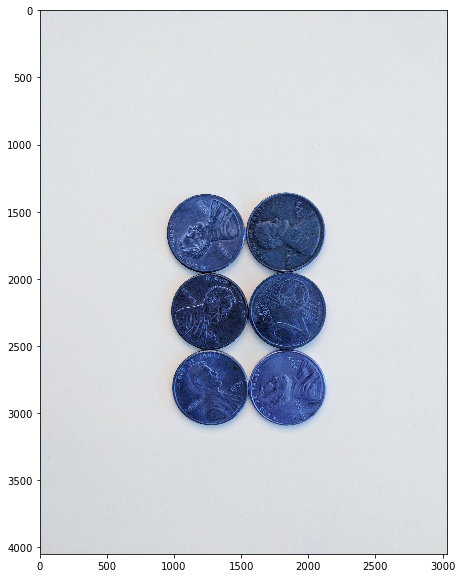

In [4]:
coins = cv2.imread('C:/OpenCV/DATA/pennies.jpg')     
display(coins)

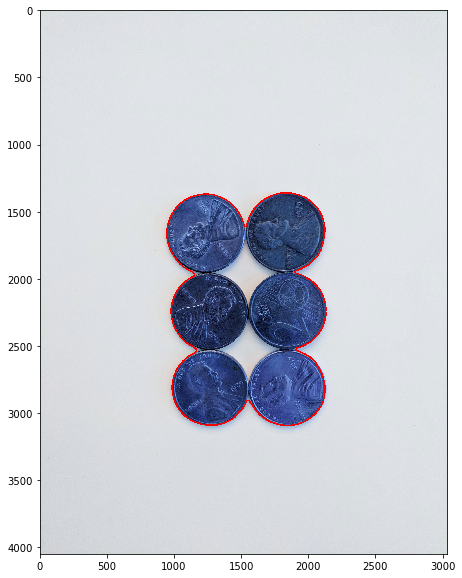

In [5]:
# this method wont work but lets try.
# 1. apply median blur
# 2. grayscale
# 3. binary threshold
# 4. find contours 

blurred = cv2.medianBlur(coins, 25)

graycoins = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

ret, threshcoins = cv2.threshold(graycoins, 160, 255, cv2.THRESH_BINARY_INV)

image, contours, hierarchy = cv2.findContours(threshcoins.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(coins, contours, i , (255,0,0), 10)

display(coins)
#missing parts; we need watershed algorithm

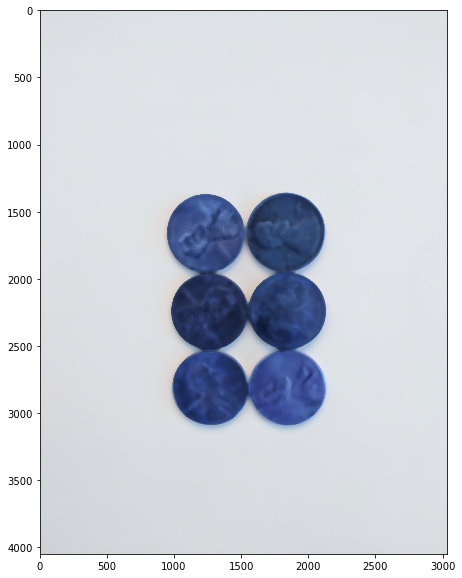

In [6]:
coins = cv2.imread('C:/OpenCV/DATA/pennies.jpg')     

coins = cv2.medianBlur(coins, 35)

display(coins)

In [7]:
gray = cv2.cvtColor(coins,cv2.COLOR_BGR2GRAY)

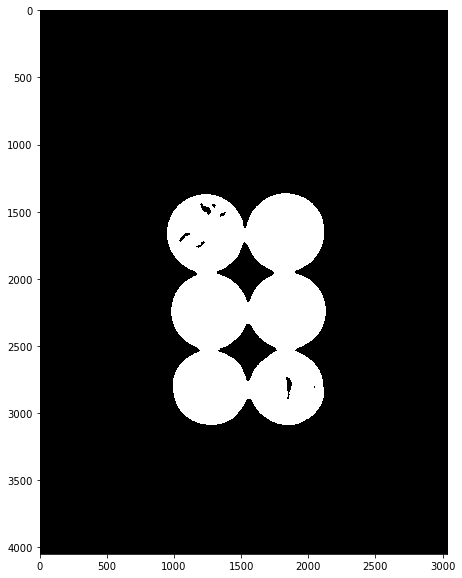

In [8]:
ret, th1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
display(th1)
# doesnt work since threshold doesnt give us clear img

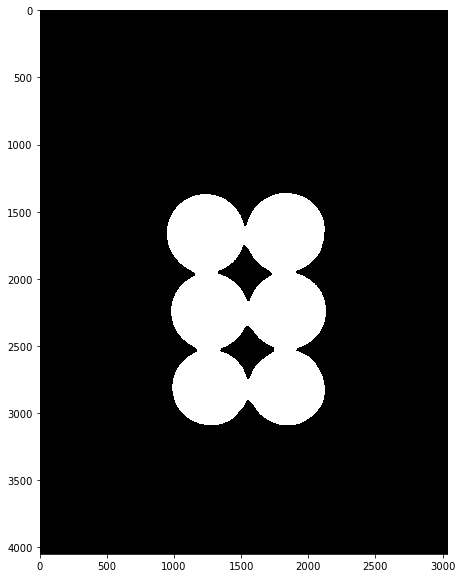

In [9]:
#So now we have use OTSU's Method instead (works very well with watershed)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
display(thresh)
#much cleaner img now

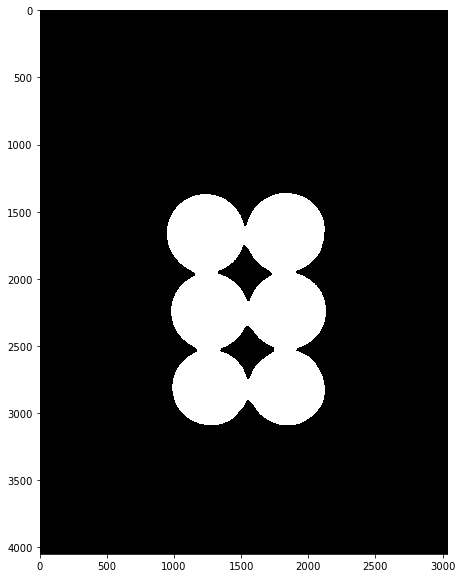

In [32]:
# remove noise

kernel = np.ones((3,3),np.uint8)
# MORPH_OPEN reduces noise well (review morphology operators in previous section)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

display(opening)

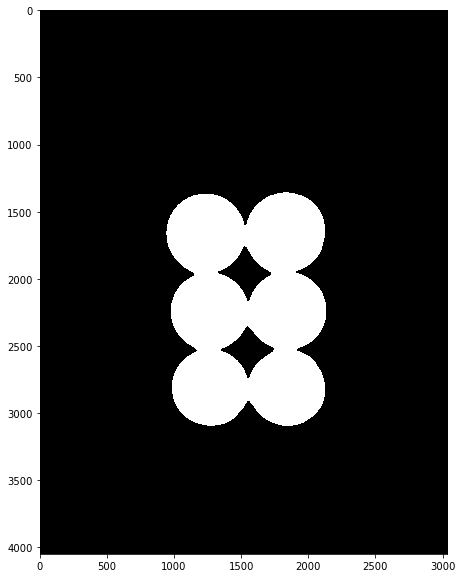

In [31]:
sure_bg = cv2.dilate(opening,kernel,iterations=3)
display(sure_bg,cmap='gray')

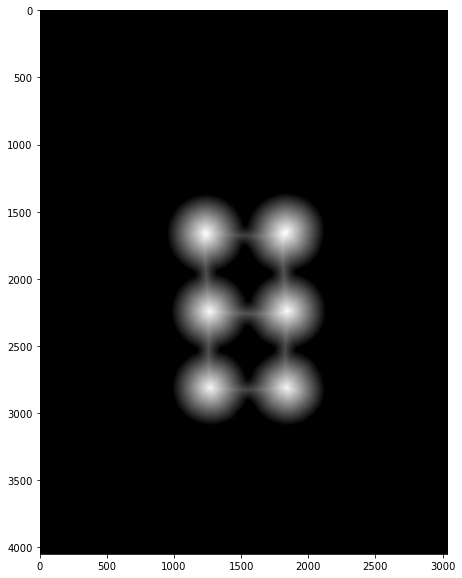

In [12]:
# Finding sure foreground area (distance transform)
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

display(dist_transform)

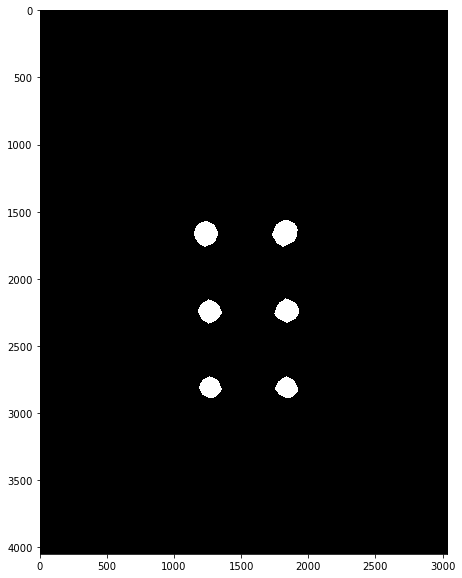

In [13]:
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
display(sure_fg)

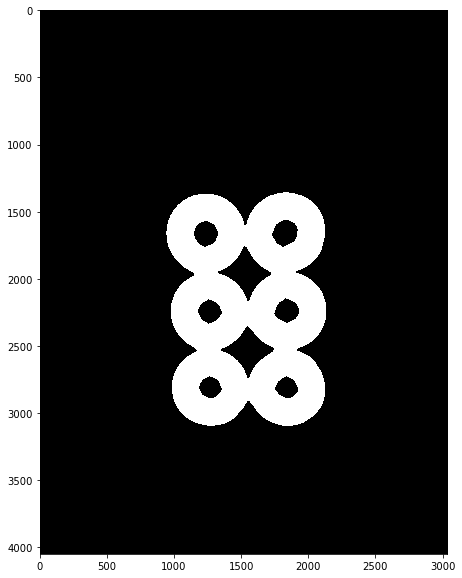

In [15]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
display(unknown)

In [16]:
#sure_fg = the six white points
ret , markers = cv2.connectedComponents(sure_fg)
markers = markers - 1

In [23]:
markers

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

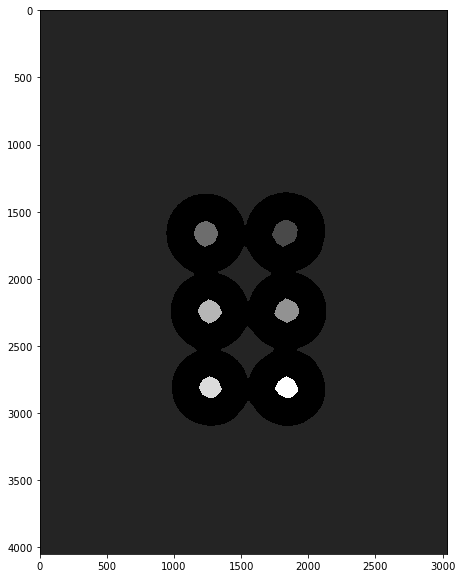

In [24]:
markers[unknown==255] = 0

display(markers)

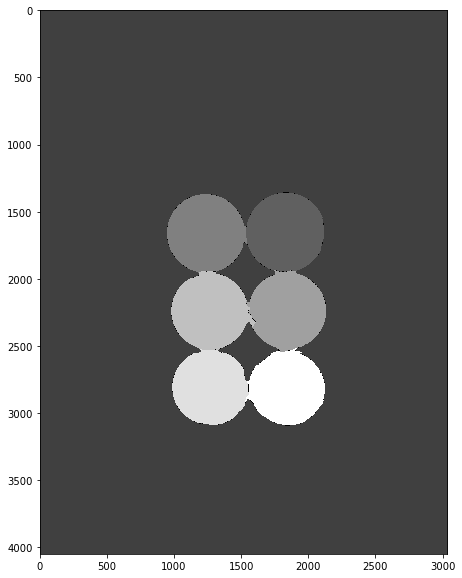

In [26]:
markers = cv2.watershed(coins,markers)

display(markers)

In [27]:
#find contours again 

image, contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# For every entry in contours
for i in range(len(contours)):
    
    # last column in the array is -1 if an external contour (no contours inside of it)
    if hierarchy[0][i][3] == -1:
        
        # We can now draw the external contours from the list of contours
        cv2.drawContours(coins, contours, i, (255, 0, 0), 10)

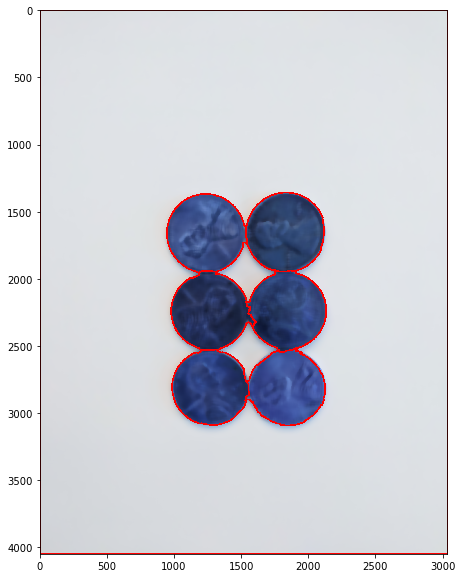

In [28]:
display(coins)

In [29]:
#SUMMARY: Steps of watershed algorithm

# 1. read in img
# 2. blur img
# 3. convert to grayscale
# 4. threshold with OTSU
# 5. remove noise (optional)
# 6. grab sure_bg through dilation
# 7. grab sure_fg with distance transform and then thresholding
# 8. subtract sure_bg by sure_fg = unkown region (watershed algorithm needs this unknown region)
# 9. grab markers
# 10. apply watershed algorithm
# 11. use contours again to find edges + draw them onto the original img